In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


In [2]:
seattle_neighborhoods_file = '/mnt/c/Users/taryn/OneDrive - UW/Documents/PugetSoundHousing/2020_ESS_Survey/SeattleNeighborhoods/Neighborhoods.shp'
seattle_neighborhoods = gpd.read_file(seattle_neighborhoods_file)

In [3]:
survey_file = '/mnt/c/Users/taryn/OneDrive - UW/Documents/PugetSoundHousing/2020_ESS_Survey/2020_ESS_GraduateHousingSurvey_Cleaned.csv'
survey_year = 2020
responses = pd.read_csv(survey_file, converters={'cost_utilitiesincl': lambda x: x.split(';'),
                                                 'cost_other': lambda x: x.split(';'),
                                                 'income_sources': lambda x: x.split(';'),
                                                 'housing_parking': lambda x: x.split(';'),
                                                 'commute_mode': lambda x: x.split(';'),
                                                 'history_howtofind': lambda x: x.split(';')})
responses.keys()

Index(['timestamp', 'program', 'cohort', 'income_monthly', 'income_sources',
       'income_altsources', 'income_shared', 'income_support',
       'income_comments', 'location_city', 'location_neighborhood',
       'location_altnames', 'location_rating', 'location_comments',
       'cost_rentown', 'cost_monthly', 'cost_utilitiesincl', 'cost_utilities',
       'cost_other', 'cost_upfront', 'cost_roomshare', 'cost_residence',
       'cost_lease', 'cost_representative', 'cost_concern', 'cost_comments',
       'people_number', 'people_numgrads', 'people_numessgrads',
       'people_family', 'people_comments', 'housing_type', 'housing_bedrooms',
       'housing_bathrooms', 'housing_parking', 'housing_laundry',
       'housing_petsokay', 'housing_havepets', 'housing_accessible',
       'housing_heating', 'housing_ac', 'housing_quality', 'housing_comments',
       'commute_mode', 'commute_bike', 'commute_walk', 'commute_car',
       'commute_transit', 'commute_transfers', 'commute_stopdistanc

In [4]:
# Data cleaning

# -- create new column in seattle_neighborhoods for neighborhood name format in survey
seattle_neighborhoods['neighborhood'] = ''
for i in seattle_neighborhoods.index:
    s_hood = seattle_neighborhoods.loc[i].S_HOOD
    l_hood = seattle_neighborhoods.loc[i].L_HOOD
    if l_hood == 'CENTRAL AREA':
        l_hood = 'CENTRAL DISTRICT'
    if l_hood is not None and 'NO BROADER TERM' not in l_hood:
        seattle_neighborhoods['neighborhood'].loc[i] = (s_hood+' ('+l_hood.title()+')')
    else:
        seattle_neighborhoods['neighborhood'].loc[i] = s_hood
seattle_neighborhoods.at[seattle_neighborhoods[seattle_neighborhoods.neighborhood == 'University District (University District)'].index.values[0], 'neighborhood'] = 'University District'
# -- merge seattle neighborhoods geodataframe with raw responses
summary_responses = responses.groupby('location_neighborhood').mean()
summary_responses['totalnum'] = responses.location_neighborhood.value_counts()
geo_responses = seattle_neighborhoods.merge(summary_responses, left_on='neighborhood', right_on='location_neighborhood')

# -- common dataframe subsets
doctoral = responses[responses.program == 'Doctoral']
message = responses[responses.program == 'MESSAGe']
renters = responses[responses.cost_rentown == 'Rent']

# -- additional calculations
renters['cost_total'] = renters.cost_utilities + renters.cost_monthly
geo_responses = geo_responses.merge(renters.groupby('location_neighborhood').mean().cost_total, left_on='neighborhood', right_on='location_neighborhood')

# -- function warning for small number statistics
def statsWarning():
    print('<< Warning! Small number statistics! Use cautiously! >>')

# -- function for plotting neighborhood outlines
def showNeighborhoodOutlines(ax):
    seattle_neighborhoods.geometry.boundary.plot(ax=ax, edgecolor='black', color=None, linewidth=0.5)



This survey received 39 responses.

Broken down by program:
Doctoral            29
MESSAGe              9
Research Masters     1

Broken down by cohort entry year:
2019    13
2018     5
2017     3
2016     6
2015     6
2014     3
2013     1
2012     1


<AxesSubplot:title={'center':'Respondent cohort'}, xlabel='Year', ylabel='Count'>

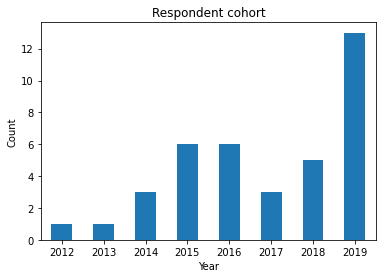

In [5]:
# SURVEY DEMOGRAPHICS

# How many people responded to the survey?
print('\nThis survey received {} responses.'.format(len(responses)))

# Break down responses by program
print('\nBroken down by program:')
print(responses.program.value_counts(dropna=False).to_string())

# Break down responses by cohort
print('\nBroken down by cohort entry year:')
print(responses.cohort.dropna().astype('int64').value_counts().sort_index(ascending=False).to_string())

# Plot cohort distribution
responses.cohort.dropna().astype('int64').value_counts().sort_index().plot.bar(rot=0, title='Respondent cohort', xlabel='Year', ylabel='Count')


In [6]:
# LOCATION

print('\nLOCATION -----------------------------------------------------------|')

# Determine which cities people live in
print('\nRespondents live in the following cities:')
print(responses.location_city.value_counts(dropna=False, sort=True, ascending=False).to_string(na_rep='not provided', header=False))

# Calculate average rating for each city
print('\nThey rated their cities on a scale of 1 to 5, 5 being the best.')
print(responses.groupby('location_city').mean().location_rating.sort_values(ascending=False).to_string(float_format='%.1f', header=False))

# Determine which neighborhood people live in
print('\nRespondents in Seattle live in these neighborhoods:')
print(responses[responses.location_city == 'Seattle'].location_neighborhood.value_counts(dropna=False, sort=True, ascending=False).to_string(na_rep='not provided', header=False))

# Link to neighborhood reference
print('You can see these neighborhood designations at https://jterrace.github.io/seattle-neighborhoods/')

# Calculate average rating for each neighborhood
print('\nThey rated their neighborhoods on a scale of 1 to 5, 5 being the best:')
statsWarning()
print(responses[responses.location_city == 'Seattle'].groupby('location_neighborhood').mean().location_rating.sort_values(ascending=False).to_string(float_format='%.1f', header=False))



LOCATION -----------------------------------------------------------|

Respondents live in the following cities:
Seattle              35
Mill Creek            1
Des Moines            1
Mountlake Terrace     1
Shoreline             1

They rated their cities on a scale of 1 to 5, 5 being the best.
Seattle             4.3
Shoreline           4.0
Mountlake Terrace   3.0
Mill Creek          3.0
Des Moines          1.0

Respondents in Seattle live in these neighborhoods:
University District                6
Wallingford                        5
Greenwood                          3
Ravenna                            3
Green Lake                         3
Wedgwood                           2
Bryant                             2
Fremont                            2
Laurelhurst                        1
Windermere                         1
Mount Baker (Rainier Valley)       1
Minor (Central District)           1
North Beacon Hill (Beacon Hill)    1
Roosevelt                          1
Broadway (

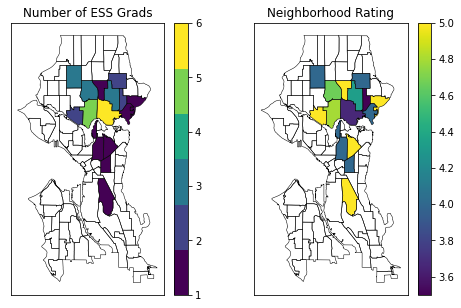

In [7]:
# Plot basic neighborhood info

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(8,5))
axs = axs.flatten()

# -- total number of students in each neighborhood
showNeighborhoodOutlines(axs[0])
geo_responses.plot(ax=axs[0], column='totalnum', cmap=plt.cm.get_cmap('viridis', geo_responses.totalnum.max()), legend=True)
axs[0].set_title('Number of ESS Grads')
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)

# -- average rating for each neighborhood
showNeighborhoodOutlines(axs[1])
geo_responses.plot(ax=axs[1], column='location_rating', legend=True)
axs[1].set_title('Neighborhood Rating')
axs[1].xaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

In [8]:

print('\nCOSTS --------------------------------------------------------------|\n')

print('While some people do own houses in the area, most grad students rent. The following information pertains to renters.')

# Calculate average overall monthly rent, and for doctoral vs MESSAGe students
print('\nThe average monthly rent is ${:.2f}.'.format(renters.cost_monthly.mean()))
print('Doctoral students are paying ${:.2f} on average.'.format(renters[renters.program == 'Doctoral'].cost_monthly.mean()))
print('MESSAGe students are paying ${:.2f} on average.'.format(renters[renters.program == 'MESSAGe'].cost_monthly.mean()))

# Calculate average monthly rent for each neighborhood
print('\nThe average rent varies with city and neighborhood:')
statsWarning()
print('\nCity:\n'+renters.groupby('location_city').mean().cost_monthly.sort_values(ascending=False).to_string(
    float_format='$%.2f', header=False))
print('\nSeattle Neighborhood:\n'+renters.groupby('location_neighborhood').mean().cost_monthly.sort_values(ascending=False).to_string(
    float_format='$%.2f', header=False))



COSTS --------------------------------------------------------------|

While some people do own houses in the area, most grad students rent. The following information pertains to renters.

The average monthly rent is $883.51.
Doctoral students are paying $850.92 on average.
MESSAGe students are paying $955.56 on average.

The average rent varies with city and neighborhood:
<< Warning! Small number statistics! Use cautiously! >>

City:
Seattle      $896.45
Mill Creek   $700.00
Des Moines   $640.00

Seattle Neighborhood:
Minor (Central District)          $1700.00
University District               $1140.00
Windermere                        $1060.00
Ravenna                           $1049.00
Fremont                            $989.00
Roosevelt                          $895.00
Eastlake (Cascade)                 $875.00
Greenwood                          $838.33
Stevens (Capitol Hill)             $820.00
Bryant                             $811.50
Wallingford                        $791.00
L

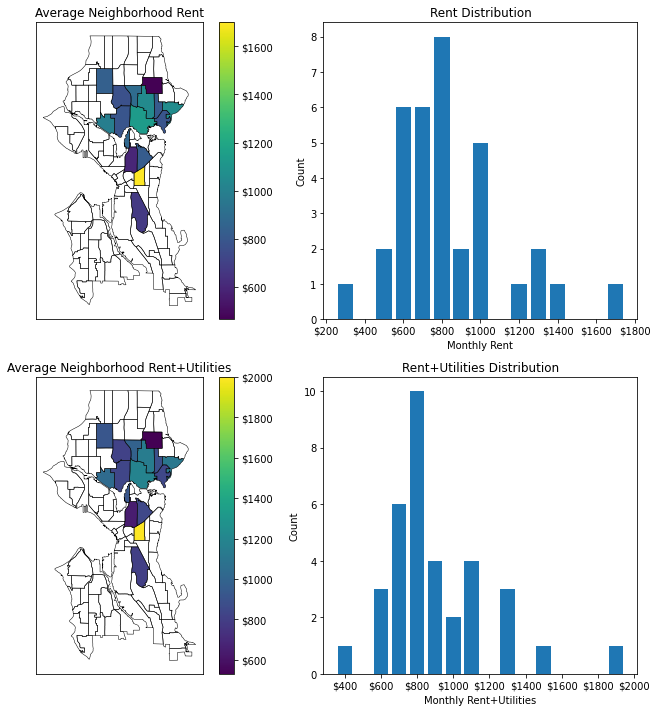

In [9]:
# Plot average rent

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axs = axs.flatten()
formatter = ticker.FormatStrFormatter('$%.0f')

# -- as map, average per neighborhood
showNeighborhoodOutlines(axs[0])
geo_responses.plot(ax=axs[0], column='cost_monthly', legend=True, legend_kwds={'format': '$%.0f'})
axs[0].set_title('Average Neighborhood Rent')
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)

# -- as histogram
axs[1].hist(renters.cost_monthly.values, rwidth=0.8, bins=list(range(300,1900,100)), align='left')
axs[1].set_title('Rent Distribution')
axs[1].set_xlabel('Monthly Rent')
axs[1].set_ylabel('Count')
axs[1].xaxis.set_major_formatter(formatter)

# -- as map, including utilities
showNeighborhoodOutlines(axs[2])
geo_responses.plot(ax=axs[2], column='cost_total', legend=True, legend_kwds={'format': '$%.0f'})
axs[2].set_title('Average Neighborhood Rent+Utilities')
axs[2].xaxis.set_visible(False)
axs[2].yaxis.set_visible(False)

# -- as histogram, including utilities
axs[3].hist(renters.cost_total.values, rwidth=0.8, bins=list(range(400,2100,100)), align='left')
axs[3].set_title('Rent+Utilities Distribution')
axs[3].set_xlabel('Monthly Rent+Utilities')
axs[3].set_ylabel('Count')
axs[3].xaxis.set_major_formatter(formatter)

plt.tight_layout()

In [10]:

print('\nThere is a lot of information that these numbers obscure. For instance, these reported rents may have utilities included, or could be split with a partner. Let''s dig deeper.')

# Cost as percent of income
print('\nOn average, students are paying {:.1f}% of their monthly income towards rent.'.format((100 * renters.cost_monthly / renters.income_monthly).replace(np.inf, 100).mean()))
print('Doctoral students are paying {:.1f}% of their income towards rent.'.format((100 * renters[renters.program == 'Doctoral'].cost_monthly / renters[renters.program == 'Doctoral'].income_monthly).replace(np.inf, 100).mean()))
print('MESSAGe students are paying {:.1f}% of their income towards rent.'.format((100 * renters[renters.program == 'MESSAGe'].cost_monthly / renters[renters.program == 'MESSAGe'].income_monthly).replace(np.inf, 100).mean()))

# Average cost of bedroom per number of rooms in residence
print('\nGenerally, the more rooms a home has, the cheaper a room is (i.e. living with roommates costs less).')
statsWarning()
print('Number of bedrooms:\n'+renters.groupby('housing_bedrooms')['cost_monthly'].mean().sort_index().to_string(float_format='$%.2f', header=False))

# Average total cost of residence per size of residence
print('\nThe total cost of a residence isn\'t always evenly divided between roommates (e.g. if some rooms are bigger than others). Here is the average total cost of residences based on size.')
statsWarning()
print('Number of bedrooms:\n'+renters.groupby('housing_bedrooms')['cost_residence'].mean().sort_index().to_string(float_format='$%.2f', header=False))

# How many people split cost of room with someone else (e.g. a partner)
print('\nAlso, many students split the cost of a room with someone else, such as a partner. {} respondents ({:.0f}%) reported sharing the cost of a room with someone else.'.format(renters.cost_roomshare.value_counts().Yes, 100*renters.cost_roomshare.value_counts(normalize=True).Yes))

# How many of these include utilities/which utilities are included
print('\nIt\'s important to note that some of these rent costs have utilities included.')
print('{:.0f}% of renters have NATURAL GAS included in their rent.'.format(100*sum(['Natural gas' in renters.cost_utilitiesincl.loc[i] for i in renters.index])/len(renters.index)))
print('{:.0f}% of renters have ELECTRICITY included in their rent.'.format(100*sum(['Electricity' in renters.cost_utilitiesincl.loc[i] for i in renters.index])/len(renters.index)))
print('{:.0f}% of renters have WATER/SEWER included in their rent.'.format(100*sum(['Water/sewer' in renters.cost_utilitiesincl.loc[i] for i in renters.index])/len(renters.index)))
print('{:.0f}% of renters have GARBAGE/RECYCLING/COMPOST included in their rent.'.format(100*sum(['Garbage/recycling/compost' in renters.cost_utilitiesincl.loc[i] for i in renters.index])/len(renters.index)))

# Adding the cost of other utilities, what are the new averages
print('\nOf course, utilities that aren\'t included in rent are still part of the monthly cost of housing. Let\'s revisit average monthly housing costs with utilities included.')
statsWarning()
print('\nThe average cost of utilities is ${:.2f}, and the average cost of rent+utilities is ${:.2f}.'.format(renters.cost_utilities.mean(), renters.cost_total.mean()))
print('\nCity:\n'+renters.groupby('location_city').mean().cost_total.sort_values(ascending=False).to_string(
    float_format='$%.2f', header=False))
print('\nSeattle Neighborhood:\n'+renters.groupby('location_neighborhood').mean().cost_total.sort_values(ascending=False).to_string(
    float_format='$%.2f', header=False))



There is a lot of information that these numbers obscure. For instance, these reported rents may have utilities included, or could be split with a partner. Lets dig deeper.

On average, students are paying 41.3% of their monthly income towards rent.
Doctoral students are paying 31.7% of their income towards rent.
MESSAGe students are paying 81.1% of their income towards rent.

Generally, the more rooms a home has, the cheaper a room is (i.e. living with roommates costs less).
<< Warning! Small number statistics! Use cautiously! >>
Number of bedrooms:
1         $950.27
2        $1001.17
3         $767.00
4         $786.00
5         $592.50
6         $900.00
Studio   $1048.75

The total cost of a residence isn't always evenly divided between roommates (e.g. if some rooms are bigger than others). Here is the average total cost of residences based on size.
<< Warning! Small number statistics! Use cautiously! >>
Number of bedrooms:
1        $1515.00
2        $2239.00
3        $2538.75
4   

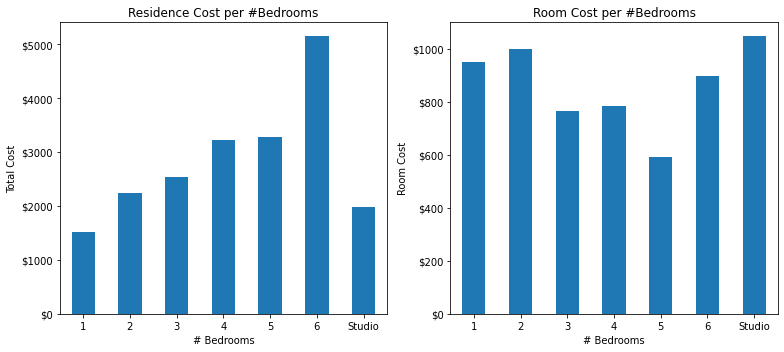

In [11]:
# Plot housing costs depending on number of bedrooms

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,5))
axs = axs.flatten()
formatter = ticker.FormatStrFormatter('$%.0f')

# -- avg residence cost by size (# bedrooms)
renters.groupby('housing_bedrooms')['cost_residence'].mean().sort_index(ascending=True).plot.bar(ax=axs[0], title='Residence Cost per #Bedrooms', xlabel='# Bedrooms', ylabel='Total Cost', rot=0)
axs[0].yaxis.set_major_formatter(formatter)

# -- avg bedroom cost by size (# bedrooms)
renters.groupby('housing_bedrooms')['cost_monthly'].mean().sort_index(ascending=True).plot.bar(ax=axs[1], title='Room Cost per #Bedrooms', xlabel='# Bedrooms', ylabel='Room Cost', rot=0)
axs[1].yaxis.set_major_formatter(formatter)

plt.tight_layout()


In [12]:
print('\nRent and utilities may be easy enough to figure out, but sometimes housing comes with additional costs.')

# Up-front move-in costs
# print('Moving can cost a lot up front.')
# TODO: update survey to make this question multiple choice/checkboxes for easier analysis.

# Other monthly housing costs (parking, laundry, etc)
print('\nThere are other monthly housing-related costs that can add up, too.')
print('{:.0f}% of renters also pay for PARKING.'.format(100*sum(['Parking' in renters.cost_other.loc[i] for i in renters.index])/len(renters.index)))
print('{:.0f}% of renters also pay for LAUNDRY.'.format(100*sum(['Laundry' in renters.cost_other.loc[i] for i in renters.index])/len(renters.index)))
print('{:.0f}% of renters also pay for STORAGE.'.format(100*sum(['Storage' in renters.cost_other.loc[i] for i in renters.index])/len(renters.index)))
print('{:.0f}% of renters also pay for PET RENT.'.format(100*sum(['Pet rent' in renters.cost_other.loc[i] for i in renters.index])/len(renters.index)))
# TODO: add bike storage to survey options, make other not-fillable

print('\nLiving in the Seattle area is expensive. On average, students ranked their concern about their ability to afford housing as {:.2f} out of 5, 5 being the highest.'.format(renters.cost_concern.mean()))

# Other comments
print('\nWhat else do we have to say about our housing costs?')
print('',*[n for n in responses.cost_comments if n is not np.nan], sep='\n-')



Rent and utilities may be easy enough to figure out, but sometimes housing comes with additional costs.

There are other monthly housing-related costs that can add up, too.
6% of renters also pay for PARKING.
19% of renters also pay for LAUNDRY.
3% of renters also pay for STORAGE.
3% of renters also pay for PET RENT.

Living in the Seattle area is expensive. On average, students ranked their concern about their ability to afford housing as 2.81 out of 5, 5 being the highest.

What else do we have to say about our housing costs?

-The house has been rented continuously by friends for the past 6-7 years. 
-I don't like where I live, and I am too poor to afford to move. 
-Probably going to go up significantly when the new light rail stations open up
-utilities vary a lot
-I contribute a relatively small amount to the mortgage every month, but it isn't exactly "rent" 
-I live with my mother, who owns the house, so I don't pay rent and my living situation is very atypical.  
-When I found 

<AxesSubplot:title={'center':'Housing Affordability Concern'}, xlabel='low <--   Degree of Concern   --> high', ylabel='Count'>

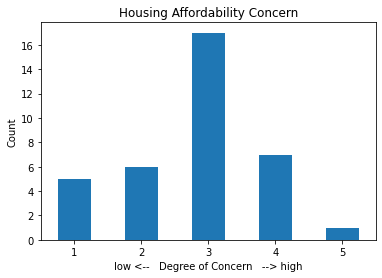

In [13]:
# Plot cost concerns

fig, ax = plt.subplots()
renters.cost_concern.value_counts().sort_index().plot.bar(rot=0, title='Housing Affordability Concern', xlabel='low <--   Degree of Concern   --> high', ylabel='Count')

In [14]:

print('\nINCOME -------------------------------------------------------------|')

print('\nWe touched on cost as a percentage of income. Let''s check on the income sources people have to pay their rent. This is very different for funded research students vs the MESSAGe program.')

# Average monthly income
print('\nDoctoral students, on average, make ${:.2f} per month.'.format(doctoral.income_monthly.mean()))
print('MESSAGe students, on average, make ${:.2f} per month.'.format(message.income_monthly.mean()))

# Income sources
print('\nDoctoral students earn income from the following sources:')
print('{:.0f}% from TA/RA/GSA with tuition exemption'.format(100*sum(['TA/RA/GSA - with tuition exemption' in doctoral.income_sources.loc[i] for i in doctoral.index])/len(doctoral.index)))
print('{:.0f}% from TA/RA/GSA without tuition exemption'.format(100*sum(['TA/RA/GSA - without tuition exemption' in doctoral.income_sources.loc[i] for i in doctoral.index])/len(doctoral.index)))
print('{:.0f}% from UW hourly position'.format(100*sum(['UW hourly position' in doctoral.income_sources.loc[i] for i in doctoral.index])/len(doctoral.index)))
print('{:.0f}% from Fellowship/Traineeship'.format(100*sum(['Fellowship/Traineeship' in doctoral.income_sources.loc[i] for i in doctoral.index])/len(doctoral.index)))
print('{:.0f}% from Non-UW internship'.format(100*sum(['Non-UW internship' in doctoral.income_sources.loc[i] for i in doctoral.index])/len(doctoral.index)))
print('{:.0f}% from Non-UW position (as primary income source)'.format(100*sum(['Non-UW position - primary source of income' in doctoral.income_sources.loc[i] for i in doctoral.index])/len(doctoral.index)))
print('{:.0f}% from Non-UW position (as supplementary income source)'.format(100*sum(['Non-UW position - supplementary source of income' in doctoral.income_sources.loc[i] for i in doctoral.index])/len(doctoral.index)))
print('{:.0f}% have no income source'.format(100*sum(['None' in doctoral.income_sources.loc[i] for i in doctoral.index])/len(doctoral.index)))

print('\nMESSAGe students earn income from the following sources:')
print('{:.0f}% from TA/RA/GSA with tuition exemption'.format(100*sum(['TA/RA/GSA - with tuition exemption' in message.income_sources.loc[i] for i in message.index])/len(message.index)))
print('{:.0f}% from TA/RA/GSA without tuition exemption'.format(100*sum(['TA/RA/GSA - without tuition exemption' in message.income_sources.loc[i] for i in message.index])/len(message.index)))
print('{:.0f}% from UW hourly position'.format(100*sum(['UW hourly position' in message.income_sources.loc[i] for i in message.index])/len(message.index)))
print('{:.0f}% from Fellowship/Traineeship'.format(100*sum(['Fellowship/Traineeship' in message.income_sources.loc[i] for i in message.index])/len(message.index)))
print('{:.0f}% from Non-UW internship'.format(100*sum(['Non-UW internship' in message.income_sources.loc[i] for i in message.index])/len(message.index)))
print('{:.0f}% from Non-UW position (as primary income source)'.format(100*sum(['Non-UW position - primary source of income' in message.income_sources.loc[i] for i in message.index])/len(message.index)))
print('{:.0f}% from Non-UW position (as supplementary income source)'.format(100*sum(['Non-UW position - supplementary source of income' in message.income_sources.loc[i] for i in message.index])/len(message.index)))
print('{:.0f}% have no income source'.format(100*sum(['None' in message.income_sources.loc[i] for i in message.index])/len(message.index)))

# Alternate sources
print('\nSome students have alternate (non-work) sources of income, such as help from family, or student loans.')
print('{:.0f}% of doctoral students have an alternate source of financial support.'.format(100 * doctoral.income_altsources.value_counts().Yes / doctoral.income_altsources.count()))
print('{:.0f}% of MESSAGe students have an alternate source of financial support.'.format(100 * message.income_altsources.value_counts().Yes / message.income_altsources.count()))

# Expenses shared
print('\nSome students share their expenses with a partner.')
print(responses.income_shared.value_counts().to_string(header=None))

# Supporting others on income
print('\nSometimes our income needs to support more than just ourselves. {:.0f}% of students support someone else (e.g. a dependent) on their income.'.format(100 * responses.income_support.value_counts().Yes / responses.income_support.count()))

# Other comments
print('\nWhat else do we have to say about our income as it relates to housing?')
print('',*[n for n in responses.income_comments if n is not np.nan], sep='\n-')



INCOME -------------------------------------------------------------|

We touched on cost as a percentage of income. Lets check on the income sources people have to pay their rent. This is very different for funded research students vs the MESSAGe program.

Doctoral students, on average, make $2699.46 per month.
MESSAGe students, on average, make $983.33 per month.

Doctoral students earn income from the following sources:
97% from TA/RA/GSA with tuition exemption
10% from TA/RA/GSA without tuition exemption
10% from UW hourly position
31% from Fellowship/Traineeship
0% from Non-UW internship
7% from Non-UW position (as primary income source)
14% from Non-UW position (as supplementary income source)
3% have no income source

MESSAGe students earn income from the following sources:
11% from TA/RA/GSA with tuition exemption
0% from TA/RA/GSA without tuition exemption
11% from UW hourly position
0% from Fellowship/Traineeship
33% from Non-UW internship
22% from Non-UW position (as primar

In [15]:

print('\nHOUSEMATES ---------------------------------------------------------|')
print('\nWe saw that having more roommates tends to be cheaper. Let\'s look at how many people graduate student renters typically live with.')

# Number of housemates
print('\nTotal number of people living in household:\n'+renters.people_number.value_counts().sort_index(ascending=True).to_string(header=False))

# Number of grad student housemates
print('\nNumber of housemates who are grad students:\n'+renters.people_numgrads.value_counts().sort_index(ascending=True).to_string(header=False))

# Number of ESS housemates
print('\nNumber of housemates who are ESS grad students:\n'+renters.people_numessgrads.value_counts().sort_index(ascending=False).to_string(header=False))

# Live with a partner, dependents, other family
print('\nAdditionally, {:.0f}% of students who rent live with a partner, dependents, or other family.'.format(100 * renters.people_family.value_counts().Yes / renters.people_family.count()))

# Other comments
print('\nWhat else do we have to say about living with housemates?')
print('',*[n for n in responses.people_comments if n is not np.nan], sep='\n-')



HOUSEMATES ---------------------------------------------------------|

We saw that having more roommates tends to be cheaper. Let's look at how many people graduate student renters typically live with.

Total number of people living in household:
2          14
3           6
4           4
5           4
6           3
Just me     5

Number of housemates who are grad students:
1           8
2           3
3           4
Just me    21

Number of housemates who are ESS grad students:
Just me    32
1           4

Additionally, 47% of students who rent live with a partner, dependents, or other family.

What else do we have to say about living with housemates?

-I found my apartment via Craigslist (my roommate advertised).
-Don't live on the ground floor
-live with mother and two dogs
-I live with a former partner and my brother. I advertised to listservs that I was looking for housing, but nobody took me up on it.
-I live with my partner (recent UW grad student). Neither of us would be able to 

<AxesSubplot:title={'center':'#ESS Grad Housemates in Home'}, xlabel='Number', ylabel='Count'>

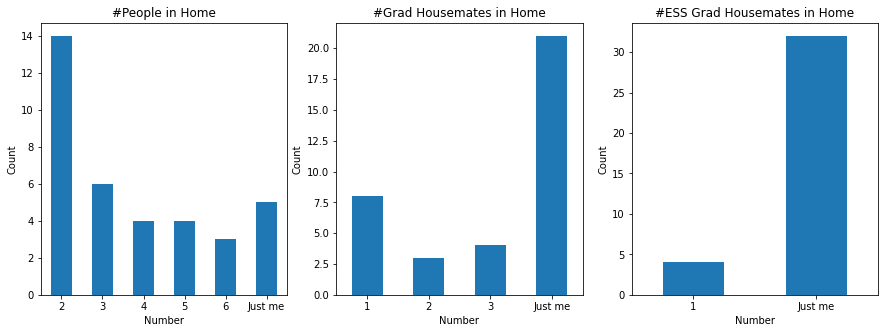

In [16]:
# Plot housemate numbers

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axs = axs.flatten()

renters.people_number.value_counts().sort_index(ascending=True).plot.bar(ax=axs[0], rot=0, title='#People in Home', ylabel='Count', xlabel='Number')

renters.people_numgrads.value_counts().sort_index(ascending=True).plot.bar(ax=axs[1], rot=0, title='#Grad Housemates in Home', ylabel='Count', xlabel='Number')

renters.people_numessgrads.value_counts().sort_index(ascending=True).plot.bar(ax=axs[2], rot=0, title='#ESS Grad Housemates in Home', ylabel='Count', xlabel='Number')

In [17]:

print('\nHOUSING CHARACTERISTICS --------------------------------------------|')
print('\nLet\'s see what characteristics are typical of graduate student renter\'s homes.')

# Housing type
print('\nStudents live in a variety of housing types:\n'+renters.housing_type.value_counts().to_string(header=False))

# Lease term
print('\nMost students are on a 12-month lease term.\n'+renters.cost_lease.value_counts().to_string(header=False))
# TODO: move lease to housing characteristics in survey

# Number of bedrooms
print('\nWe live in a variety of home sizes.')
print('Number of bedrooms:\n'+renters.housing_bedrooms.value_counts().sort_index(ascending=True).to_string(header=False))

# Number of bathrooms
print('\nAnd most of us share bathrooms.')
print('Number of bathrooms:\n'+renters.housing_bathrooms.value_counts().sort_index(ascending=True).to_string(header=False))

# Parking available
print('\nThere are so many possible parking situations!')
print('{:.0f}% have free street parking'.format(100*sum(['Free street parking' in renters.housing_parking.loc[i] for i in renters.index])/len(renters.index)))
print('{:.0f}% have a free reserved spot (e.g. in garage)'.format(100*sum(['Free reserved spot (e.g. in garage)' in renters.housing_parking.loc[i] for i in renters.index])/len(renters.index)))
print('{:.0f}% have restricted street parking (e.g. need city permit)'.format(100*sum(['Restricted street parking (e.g. need city permit)' in renters.housing_parking.loc[i] for i in renters.index])/len(renters.index)))
print('{:.0f}% have a paid reserved spot'.format(100*sum(['Paid reserved spot' in renters.housing_parking.loc[i] for i in renters.index])/len(renters.index)))
print('{:.0f}% have no parking available'.format(100*sum(['No parking available' in renters.housing_parking.loc[i] for i in renters.index])/len(renters.index)))

# Laundry facilities
print('\nMost of us can do laundry at home.\n'+renters.housing_laundry.value_counts().to_string(header=False))

# Pets allowed
print('\nThe majority of rentals allow pets, too.\n'+renters.housing_petsokay.value_counts().to_string(float_format='%.0f', header=False))
print('And {:.0f}% of graduate students do have pets!'.format(100*renters.housing_havepets.value_counts(normalize=True).Yes))

# Accessibility
print('\nAccessible homes are out there, but they\'re not the norm.')
print(renters.housing_accessible.value_counts().to_string(header=False))

# Heating source
print('\nWe get our heat from natural gas or electricity.\n'+renters.housing_heating.value_counts().to_string(header=False))

# Air conditioning
print('\nAir conditioning is not common.\n'+renters.housing_ac.value_counts().to_string(header=False))

# Overall quality of home
print('\nOverall, we think our homes are alright!\n'+renters.housing_quality.value_counts().to_string(header=False))

# Other comments
print('\nWhat else do we have to say about our housing itself?')
print('',*[n for n in responses.housing_comments if n is not np.nan], sep='\n-')




HOUSING CHARACTERISTICS --------------------------------------------|

Let's see what characteristics are typical of graduate student renter's homes.

Students live in a variety of housing types:
Apartment                             14
House                                 11
Townhouse / duplex / similar           8
Condominium                            2
UW housing (such as Radford Court)     1

Most students are on a 12-month lease term.
12-month          32
Month-to-month     3
14-month           1

We live in a variety of home sizes.
Number of bedrooms:
1         11
2          6
3          5
4          5
5          4
6          1
Studio     4

And most of us share bathrooms.
Number of bathrooms:
1.0    21
2.0    10
2.5     4
3.0     1

There are so many possible parking situations!
58% have free street parking
47% have a free reserved spot (e.g. in garage)
17% have restricted street parking (e.g. need city permit)
19% have a paid reserved spot
3% have no parking available

Most 

<AxesSubplot:title={'center':'Housing type'}>

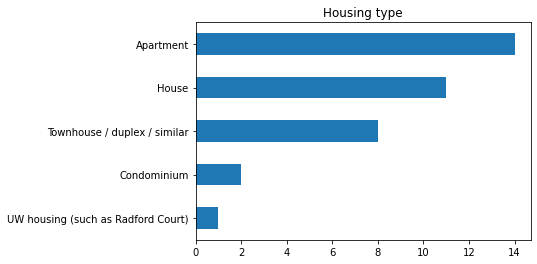

In [18]:
renters.housing_type.value_counts(ascending=True).plot.barh(title='Housing type')

<AxesSubplot:title={'center':'Number of bathrooms'}, xlabel='Number', ylabel='Count'>

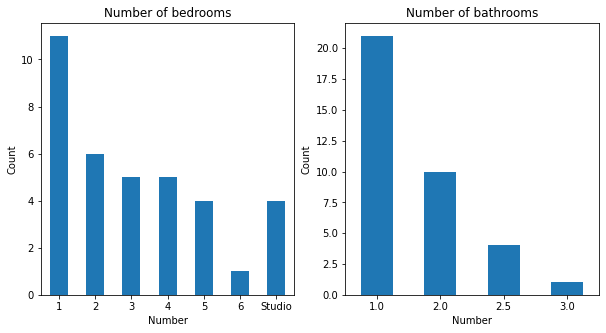

In [19]:
# Plot number of bedrooms and bathrooms

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axs = axs.flatten()

# -- Number of bedrooms
renters.housing_bedrooms.value_counts().sort_index().plot.bar(ax=axs[0], rot=0, title='Number of bedrooms', ylabel='Count', xlabel='Number')

# -- Number of bathrooms
renters.housing_bathrooms.value_counts().sort_index().plot.bar(ax=axs[1], rot=0, title='Number of bathrooms', ylabel='Count', xlabel='Number')

<AxesSubplot:title={'center':'Overall quality'}>

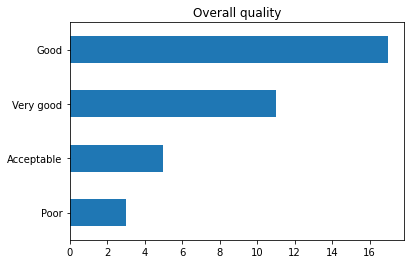

In [20]:
renters.housing_quality.value_counts(ascending=True).plot.barh(title='Overall quality')

In [21]:

print('\nCOMMUTE ------------------------------------------------------------|')
print('\nHow do graduate students get to campus, and how long does it take?')

# Commute mode
print('\nWe use a variety of commute modes to get to campus.')
print('{:.0f}% take the bus.'.format(100*sum(['Bus' in responses.commute_mode.loc[i] for i in responses.index])/len(responses.index)))
print('{:.0f}% take light rail.'.format(100*sum(['Light rail' in responses.commute_mode.loc[i] for i in responses.index])/len(responses.index)))
print('{:.0f}% bike.'.format(100*sum(['Bike' in responses.commute_mode.loc[i] for i in responses.index])/len(responses.index)))
print('{:.0f}% walk.'.format(100*sum(['Walk' in responses.commute_mode.loc[i] for i in responses.index])/len(responses.index)))
print('{:.0f}% drive alone.'.format(100*sum(['Drive (alone)' in responses.commute_mode.loc[i] for i in responses.index])/len(responses.index)))
print('{:.0f}% carpool.'.format(100*sum(['Drive (carpool)' in responses.commute_mode.loc[i] for i in responses.index])/len(responses.index)))

# Neighborhood -> average bike time
print('\nHere is the average bike commute time from different neighborhoods:')
print(responses.groupby('location_neighborhood')['commute_bike'].mean().dropna().sort_values().to_string(float_format='%.0f', header=None))

# Neighborhood -> average walk time
print('\nHere is the average walk commute time from different neighborhoods:')
print(responses.groupby('location_neighborhood')['commute_walk'].mean().dropna().sort_values().to_string(float_format='%.0f', header=None))

# Neighborhood -> average car time
print('\nHere is the average drive commute time from different neighborhoods:')
print(responses.groupby('location_neighborhood')['commute_car'].mean().dropna().sort_values().to_string(float_format='%.0f', header=None))

# Neighborhood -> average transit time
print('\nHere is the average transit commute time from different neighborhoods:')
print(responses.groupby('location_neighborhood')['commute_transit'].mean().dropna().sort_values().to_string(float_format='%.0f', header=None))

# Neighborhood -> number of transit stops
print('\nHere is the average number of transit transfers from different neighborhoods:')
print(responses.groupby('location_neighborhood')['commute_transfers'].mean().dropna().sort_values().to_string(float_format='%.0f', header=None))

# Distance to transit stop
print('\nHere is the typical distance from home to a transit stop in different neighborhoods:')
print(responses.groupby('location_neighborhood')['commute_stopdistance'].value_counts().to_string(header=None))
# TODO: in survey change this to numerical value input (range slider?)

# Have a car or not
print('\nAlthough most of us do not drive to campus, many of us do have cars.')
print(responses.commute_havecar.value_counts().to_string(header=None))

# Other comments
print('\nWhat else do we have to say about our commutes?')
print('', *[n for n in responses.commute_comments if n is not np.nan], sep='\n-')



COMMUTE ------------------------------------------------------------|

How do graduate students get to campus, and how long does it take?

We use a variety of commute modes to get to campus.
74% take the bus.
15% take light rail.
46% bike.
38% walk.
8% drive alone.
3% carpool.

Here is the average bike commute time from different neighborhoods:
University District                7
Wedgwood                          10
Bryant                            15
Fremont                           15
Laurelhurst                       15
Wallingford                       16
Windermere                        20
Green Lake                        23
Mount Baker (Rainier Valley)      35
North Beacon Hill (Beacon Hill)   45

Here is the average walk commute time from different neighborhoods:
University District   16
Eastlake (Cascade)    20
Ravenna               30
Wallingford           30
Bryant                40
Fremont               45
Green Lake            52
Wedgwood              60

Here is the 

Text(0.5, 1.0, 'Commute mode')

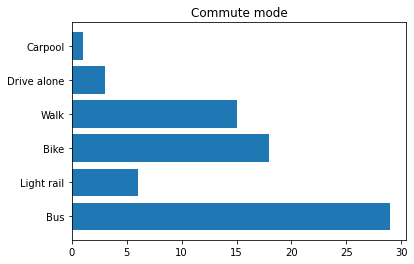

In [22]:
commute_mode = {'Bus': sum(['Bus' in i for i in responses.commute_mode]),
                'Light rail': sum(['Light rail' in i for i in responses.commute_mode]),
                'Bike': sum(['Bike' in i for i in responses.commute_mode]),
                'Walk': sum(['Walk' in i for i in responses.commute_mode]),
                'Drive alone': sum(['Drive (alone)' in i for i in responses.commute_mode]),
                'Carpool': sum(['Drive (carpool)' in i for i in responses.commute_mode])}

plt.barh(list(commute_mode.keys()), commute_mode.values())
plt.title('Commute mode')

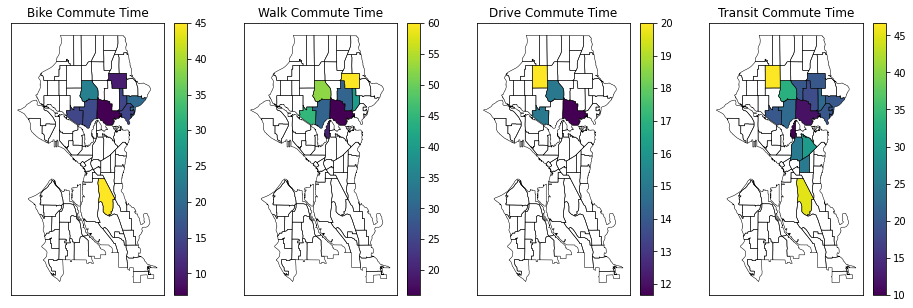

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 5))
axs = axs.flatten()

showNeighborhoodOutlines(axs[0])
geo_responses.plot(ax=axs[0], column='commute_bike', legend=True)
axs[0].set_title('Bike Commute Time')
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)

showNeighborhoodOutlines(axs[1])
geo_responses.plot(ax=axs[1], column='commute_walk', legend=True)
axs[1].set_title('Walk Commute Time')
axs[1].xaxis.set_visible(False)
axs[1].yaxis.set_visible(False)

showNeighborhoodOutlines(axs[2])
geo_responses.plot(ax=axs[2], column='commute_car', legend=True)
axs[2].set_title('Drive Commute Time')
axs[2].xaxis.set_visible(False)
axs[2].yaxis.set_visible(False)

showNeighborhoodOutlines(axs[3])
geo_responses.plot(ax=axs[3], column='commute_transit', legend=True)
axs[3].set_title('Transit Commute Time')
axs[3].xaxis.set_visible(False)
axs[3].yaxis.set_visible(False)

In [24]:
# HISTORY
ratings = {'Extremely important': 5, 'Very important': 4, 'Moderately important': 3, 'Slightly important': 2, 'Not at all important': 1}

print('\nWhen searching for housing, students considered many factors. Given the following rating scheme,')
print(*ratings.items(), sep='\n')
print('these are their average ratings for different factors:')
print('\nCost: {:.2f}'.format(renters.history_ratecost.replace(ratings).mean()))
print('Quality: {:.2f}'.format(renters.history_ratequality.replace(ratings).mean()))
print('Landlord: {:.2f}'.format(renters.history_ratelandlord.replace(ratings).mean()))
print('Amenities: {:.2f}'.format(renters.history_rateamenities.replace(ratings).mean()))
print('Housemates: {:.2f}'.format(renters.history_ratehousemates.replace(ratings).mean()))
print('Commute: {:.2f}'.format(renters.history_ratecommute.replace(ratings).mean()))
print('Pets: {:.2f}'.format(renters.history_ratepets.replace(ratings).mean()))
print('Neighborhood: {:.2f}'.format(renters.history_rateneighborhood.replace(ratings).mean()))
print('Family: {:.2f}'.format(renters.history_ratefamily.replace(ratings).mean()))
print('Other work: {:.2f}'.format(renters.history_rateotherwork.replace(ratings).mean()))
print('Green space: {:.2f}'.format(renters.history_rategreenspace.replace(ratings).mean()))
print('Other: {:.2f}'.format(renters.history_rateother.replace(ratings).mean()))
print('\n"Other" factors include:')
print('', *[n for n in renters.history_describeother.dropna()], sep='\n -')


When searching for housing, students considered many factors. Given the following rating scheme,
('Extremely important', 5)
('Very important', 4)
('Moderately important', 3)
('Slightly important', 2)
('Not at all important', 1)
these are their average ratings for different factors:

Cost: 4.29
Quality: 3.91
Landlord: 2.51
Amenities: 2.97
Housemates: 3.96
Commute: 3.89
Pets: 2.44
Neighborhood: 3.31
Family: 1.00
Other work: 2.41
Green space: 2.63
Other: 3.50

"Other" factors include:

 -yard for dogs and storage for outdoor gear are extremely important
 -An affordable extra bedroom (does this count as residence amenities?) to use as an office, with a cat area including litter box.
 -Overall feeling of safety (especially at night) and quietness of neighborhood


Text(0, 0.5, 'Factor')

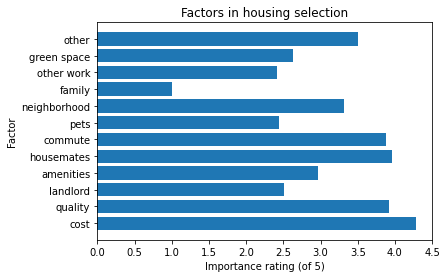

In [25]:
selection_factors = {
    'cost':     renters.history_ratecost.replace(ratings).mean(),
    'quality':     renters.history_ratequality.replace(ratings).mean(),
    'landlord':     renters.history_ratelandlord.replace(ratings).mean(),
    'amenities':     renters.history_rateamenities.replace(ratings).mean(),
    'housemates':     renters.history_ratehousemates.replace(ratings).mean(),
    'commute':     renters.history_ratecommute.replace(ratings).mean(),
    'pets':     renters.history_ratepets.replace(ratings).mean(),
    'neighborhood':     renters.history_rateneighborhood.replace(ratings).mean(),
    'family':     renters.history_ratefamily.replace(ratings).mean(),
    'other work':     renters.history_rateotherwork.replace(ratings).mean(),
    'green space':     renters.history_rategreenspace.replace(ratings).mean(),
    'other':     renters.history_rateother.replace(ratings).mean(),
}

fig, ax = plt.subplots()
ax.barh(list(selection_factors.keys()), selection_factors.values())
ax.set_title('Factors in housing selection')
ax.set_xlabel('Importance rating (of 5)')
ax.set_ylabel('Factor')

In [26]:
print('How long should you start looking for a place before you want to move? Check out these recommendations:')
print('', *[n for n in renters.history_searchtime.dropna()], sep='\n-')

How long should you start looking for a place before you want to move? Check out these recommendations:

-3 months
-It depends on how much money you have to reserve a place. If you have money to reserve a place then you can give yourself a month or so. If not then you're fucked and have to look within weeks.
-1 to 2 months
-1-2 months
-4 months
-1-2 months? But also I signed a lease within ~3 days of searching for housing & haven't moved since so I'm not the best person to ask
-at least a month
-A lot of the student-targeted housing will be available in the early summer, but a lot of places seem only to start looking for residences a month out or so.
-a month? rental properties move really fast, so unfortunately you kind of have to start looking at the last minute
-3 months
-2 months
-A month?
-2 months
-4 days
-2-3 months. If you already live in the area start looking at least six months ahead of time- gives you more time to be picky about where you live. Sometimes it is worth it to b

Also, where should you look to find housing? Here are our recommendations:


Text(0.5, 1.0, 'How to Find Housing')

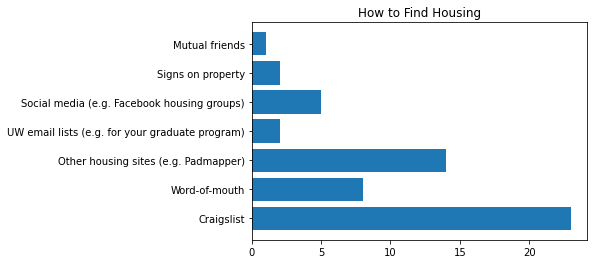

In [27]:
print('Also, where should you look to find housing? Here are our recommendations:')

how_to_find = {'Craigslist': sum(['Craigslist' in i for i in renters.history_howtofind]),
               'Word-of-mouth': sum(['Word-of-mouth' in i for i in renters.history_howtofind]),
               'Other housing sites (e.g. Padmapper)': sum(['Other housing sites (e.g. Padmapper)' in i for i in renters.history_howtofind]),
               'UW email lists (e.g. for your graduate program)': sum(['UW email lists (e.g. for your graduate program)' in i for i in renters.history_howtofind]),
               'Social media (e.g. Facebook housing groups)': sum(['Social media (e.g. Facebook housing groups)' in i for i in renters.history_howtofind]),
               'Signs on property': sum(['Signs on property' in i for i in renters.history_howtofind]),
               'Mutual friends': sum(['mutual friends' in i for i in renters.history_howtofind])}

plt.barh(list(how_to_find.keys()), how_to_find.values())
plt.title('How to Find Housing')

In [28]:
print('You might also be wondering how often people move while they\'re here. Excluding first-year students who haven\'t been here long, students average {:.0f} years in a home before moving.'.format(((survey_year - renters[(survey_year - renters.cohort) != 1.0].cohort) / renters[(survey_year - renters.cohort) != 1.0].history_numresidences).mean()))

You might also be wondering how often people move while they're here. Excluding first-year students who haven't been here long, students average 2 years in a home before moving.


In [29]:
print('{} students reported that they have been unhoused at some point during their time as a grad student.'.format(sum(renters.history_unhoused == 'Yes')))

2 students reported that they have been unhoused at some point during their time as a grad student.


In [30]:
# Other comments
print('\nWhat else do we have to say about our housing history?')
print('',*[n for n in responses.history_comments if n is not np.nan], sep='\n-')


What else do we have to say about our housing history?

-my apartment in Golden, CO was a converted motel room with utilities and internet included and on-site parking for $525 per month, that seemed like a pretty sweet deal to me at the time but has also skewed my perceptions of what's affordable!
-Finding a place to live is an ENORMOUS hassle in Seattle. I have avoided moving as much as possible, and have been fortunate to find 2 affordable places for 3 years each, and now a third I've been at for 6 months. It's like pulling teeth to find a place to live that 1) is not a scam post, 2) has a leasing agent/management company that will get back to you, 3) has a reasonable bus/walk commute to campus, 4) affordable, and 5) allows pets. 
-Stayed with friends for two months while looking for housing after leaving previous place (was a sudden departure, relationship-related).


In [31]:
# Other comments
print('\nWhat other comments do we have about housing in the Puget Sound area?')
print('',*[n for n in responses.comments if n is not np.nan], sep='\n-')


What other comments do we have about housing in the Puget Sound area?

-Don't move too far away from campus, commuting from a distance sucks. You are restricted to the hours that public transit is available which limits your ability to participate in extracurricular activities. 
-I have seen good postings on FB groups that are not strictly for housing, like pacific northwest outdoor women. it could be useful to collect names of groups that have postings like this
-if you want cheaper housing you have to go north or south of the core, but Metro ignores a lot of those neighborhoods in its bus service - I recommend stuff along the 372 route which runs all day every day and goes direct to campus.
-Zumper seemed like a good app to use in looking for places to live in my most recent search for housing, although I ended up succeeding with Craigslist in spite of all the trash I had to sift through.
-Think about the commute, distance to grocery stores, etc. before you start looking so you can 